In [1]:
from autograd import numpy as np
from autograd import grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

Some formulas

#### Objective: 
$$\nabla_{\theta,\phi} ELBO (\theta, q_{\phi}) = \sum_{n} \mathbb{E}_{q_{\phi}(z_n)} \log p_{\theta}(y_n|z_n) - D_{KL}[q_{\phi}(z_n) || p_{\theta}(z_n) ]$$

Assume $ p_{\theta}(z_n)$ has a normal prior $\mathcal{N}(0,I)$. Let the latent space have J dimensions, i.e. $\mu_n = [\mu_{1_n}, \ldots, \mu_{J_n}]$ and 
$\Sigma_n = \begin{bmatrix} \sigma_{1_n}^2 &\ldots &0 \\
\vdots & \ddots & \vdots\\
0 & \ldots & \sigma_{J_n}^2\\
\end{bmatrix}$

So, $- D_{KL}[q_{\phi}(z_n) || p_{\theta}(z_n) ] = \frac{1}{2} \sum_{j=1}^J (1+log(\sigma_{j_n}^2 )- \mu_{j_n}^2 - \sigma_{j_n}^2 )$

---

Toy example for 2 dimensional data and 1 dimensional latent space

> FYI I might have mixed up variance and standard deviation in diff places so that's fun

In [2]:
from platform import python_version

print(python_version())

3.5.6


In [3]:
# just setting these as examples 
#y_n is one data point, L is the number of samples to estimate the expectation of the likelihood,
# sigma data is the standard deviation of the data
# y_n_1 = 0.24
# y_n_2 = 0.01
y_n = np.array([0.24, 0.01])
l_n = 1
# print('Data point: \n{y_n}\n')
phi11 = np.array([0.1, 0.5])
phi12 = np.array([0.8, 0.35])
phi21 = np.array([0.35, 0.41])
phi22 = np.array([0.1, 0.91])
# print('Phi 1: \n{phi_1}\n')
# print('Phi 2: \n{phi_2}')
# L = 10
sigma_data = 0.5


In [4]:
# define inference model function for label 0
def g_phi(phi11, phi12, y_n):
    '''
    y_n is a vector of shape (,3)
    phi_1, phi_2 are vectors of shape (1, 3) 
    '''
    mu_n = np.dot(phi11, y_n)
    std_n = np.abs(np.dot(phi12, y_n)) # added abs to make this positive always
    
    return mu_n, std_n

In [5]:
# define likelihood model function
def f_theta(theta, z_n):
    '''
    This is the prediction function. 
    
    theta: one number
    z_n: ONE 1-D sampled from 
    '''
    return theta * z_n

In [6]:
# monte carlo to get expectation of the likelihood
## I added 0.000001 to help the log
def monte_carlo_expectation(theta1, mu_n, std_n, L, y_n, sigma_data):
    
    # sample L latent variables - dis cray
    seed = npr.RandomState(10)
    z_n = seed.randn(int(L),y_n.shape[0]) * std_n + mu_n
    
    # get predictions using the prediction function, i.e. f_theta
    y_n_pred = f_theta(theta1, z_n) # this is an array bc z_n is an array
    y_n_full = np.repeat(y_n.reshape(-1,1), y_n_pred.shape[0], axis = 1).T
    
    # get log likelihood of observed data
    ll = np.mean(-1/2 * np.log(2 * np.pi  * sigma_data**2 + 0.0000001) - \
                 ((y_n_pred - y_n_full)**2/(-2 * sigma_data**2)))
    
    return ll

In [7]:
l_n = 1.

In [8]:
# define objective here, which is -(loglikelihood + -KL)
def objective0(phi11, phi12, 
              theta1, 
              y_n = y_n,  L = 1e2, sigma_data = sigma_data):
    '''
    three unknowns - phi1, phi2, theta1
    '''
    mu_n1, std_n1 = g_phi(phi11, phi12, y_n)
    ll = monte_carlo_expectation(theta1, mu_n1, std_n1, L, y_n, sigma_data)        

    # KL divergence - closed form - latent space in 1D
    negKL = 1/2 * (1 + np.log(std_n1**2 + 0.0000001) - mu_n1**2 - std_n1**2)
    
    return -(ll + negKL)

In [9]:
# define objective here, which is -(loglikelihood + -KL)
def objective1(phi21, phi22, 
              theta1, 
              y_n = y_n, L = 1e2, sigma_data = sigma_data):
    '''
    three unknowns - phi1, phi2, theta1
    '''
    # two components
    # Likelihood - Monte Carlo
   
    mu_n2, std_n2 = g_phi(phi21, phi22, y_n)
    ll = monte_carlo_expectation(theta1, mu_n2, std_n2, L, y_n, sigma_data)        

    # KL divergence - closed form - latent space in 1D
    negKL = 1/2 * (1 + np.log(std_n2**2 + 0.0000001) - mu_n2**2 - std_n2**2)
    
    return -(ll + negKL)

In [10]:
## these are little checks 
objective1(phi11, phi12, theta1 = 1, y_n = y_n, L = 100000, sigma_data = 0.5)

1.2560648773260596

In [11]:
grad(objective1, 1)(phi11, phi12,  1.)

array([-1.34356389, -0.05598183])

In [12]:
objective0(phi21, phi22, theta1 = 1, y_n = y_n, L = 100000, sigma_data = 0.5)

3.107008376131402

In [13]:
grad(objective0, 1)(phi11, phi12,  1.)

array([-1.34356389, -0.05598183])

### Example

3D data  
1D latent space

In [27]:
# init_params
phi11, phi12, phi21, phi22, theta1 = np.array([0., 0.]),np.array([0.01, 0.01]),np.array([10.,10.]),np.array([0.01, 0.01]), 0.5
# L = 1000
sigma_data = 2
learning_rate = 0.001
n_iter = 1

In [28]:
# generate some fake data f_theta(z) =  2 z + 1, z ~ N(0,1)
np.random.seed(100)
mean = np.array([0,0])
cov_matrix = np.eye(2)
# print()
data1 = 2 * np.random.multivariate_normal(mean,cov_matrix,size = 200) + 9

# generate some fake data f_theta(z) =  2 z + 5, z ~ N(0,1)
mean = np.array([0,0])
cov_matrix = np.eye(2)
# print()
data2 = 2 * np.random.multivariate_normal(mean,cov_matrix,size = 200) + 5

# concatenate data
data = np.concatenate([data1, data2])

In [29]:
labels = np.concatenate([np.zeros(data1.shape[0]), np.ones(data1.shape[0])], axis =0)

In [30]:
# grad(objective1,0)(phi11, phi12, theta1)

In [31]:
# very basic impl of running gradient descent. We should make this minibatch SGD

for _ in tqdm(range(n_iter)):
    for key, y_n in enumerate((data)):
        l_n = labels[key]
#         print('l_n', l_n)
        if l_n == 0.:
            # phi11
#             print('grad(objective,0)', grad(objective,0)(phi11, phi12, phi21, phi22, theta1))
            phi11_new = phi11 - learning_rate * grad(objective0,0)(phi11, phi12,theta1)
            # phi12
            phi12_new = phi12 - learning_rate * grad(objective0,1)(phi11, phi12, theta1)
            # theta
            theta1_new = theta1 - learning_rate * grad(objective0,2)(phi11, phi12,  theta1)
            # update
            phi11, phi12, theta1 = phi11_new, phi12_new, theta1_new
        else: 
            # phi21
            phi21_new = phi21 - learning_rate * grad(objective1,0)(phi21, phi22, theta1)
            # phi22
            phi22_new = phi22 - learning_rate * grad(objective1,1)(phi21, phi22, theta1)
            # theta
            theta1_new = theta1 - learning_rate * grad(objective1,2)(phi21, phi22, theta1)
            # update
            phi21, phi22, theta1 = phi21_new, phi22_new, theta1_new
            
        # update
#         phi11, phi12, phi21, phi22, theta1 = phi11_new, phi12_new, phi21_new, phi22_new, theta1_new
#         print('\n Iteration: ', _ , '\n', phi11)
#         if key == 100:
#             break

/anaconda3/envs/am207/lib/python3.5/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/anaconda3/envs/am207/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:71: RuntimeWarning: overflow encountered in double_scalars
  lambda ans, x : lambda g: g * replace_zero(anp.conj(x), 0.) / replace_zero(ans, 1.))
/anaconda3/envs/am207/lib/python3.5/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/anaconda3/envs/am207/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/envs/am207/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/anaconda3/envs/am207/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:59: RuntimeWarning: inv

In [32]:
# grad(objective1,1)(phi21, phi22, theta1)

In [33]:
phi11, phi12, phi21, phi22, theta1

(array([-0.01164954, -0.0004854 ]),
 array([0.63857462, 0.03619061]),
 array([nan, nan]),
 array([nan, nan]),
 nan)

In [34]:
## make fake data
new_y = np.zeros(data.shape)
for k,i in enumerate(data):
    if labels[k] == 0.0:
        m, s = g_phi(phi11, phi12, i)
    else: 
        m, s = g_phi(phi21, phi22, i)

    mean = np.repeat(m, data.shape[1])
    cov = np.eye(data.shape[1])*s
    new_y[k] = f_theta(theta1, np.random.multivariate_normal(mean,cov))

ValueError: array must not contain infs or NaNs

In [ ]:
new_y.shape

In [ ]:
## make fake data
new_y = np.zeros(data.shape)
for k,i in enumerate(data):
    m, s = g_phi(phi11, phi12, i)
    mean = np.repeat(m, data.shape[1])
    cov = np.eye(data.shape[1])*s
    new_y[k] = f_theta(theta1, np.random.multivariate_normal(mean,cov))

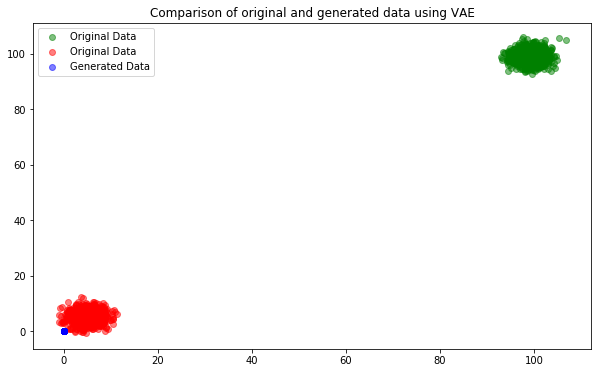

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data1[:,0],data1[:,1], color = 'g', alpha = 0.5, label = 'Original Data')
ax.scatter(data2[:,0],data2[:,1], color = 'r', alpha = 0.5, label = 'Original Data')
# ax.scatter(new_y[:100,0],new_y[:100,1], color = 'k', alpha = 0.5, label = 'Generated Data')
ax.scatter(new_y[:,0],new_y[:,1], color = 'b', alpha = 0.5, label = 'Generated Data')
ax.set_title('Comparison of original and generated data using VAE')
ax.legend()
plt.show()


---